In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname("./"), '..'))

from utils.Training import Train
from utils.CustomDataset import CustomDataset
from utils.Augmentation import augment_images
from Models.MAEClassifier import MAEViTClassifier
from Models.MaskedAutoEncoders import MaskedAutoEncoder

/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/mandakausthubh/anaconda3/envs/ViT/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this

In [2]:
# Loading the data
axion_data, cdm_data, no_sub_data = [], [], []

LabelToId = {'axion': 0, 'cdm':1, 'no_sub':2}

# Walking through the test directory and loading the data
for root, dirs, files in os.walk("../dataset/DatasetTask6A/axion/"):
    for file in files:
        axion_data.append((np.load(os.path.join(root, file), allow_pickle=True)[0]).reshape(1, 64, 64))

for root, dirs, files in os.walk("../dataset/DatasetTask6A/no_sub/"):
    for file in files:
        no_sub_data.append(np.load(os.path.join(root, file), allow_pickle=True).reshape(1, 64, 64))

for root, dirs, files in os.walk("../dataset/DatasetTask6A/cdm/"):
    for file in files:
        cdm_data.append(np.load(os.path.join(root, file), allow_pickle=True).reshape(1, 64, 64))


KeyboardInterrupt: 

In [ ]:
axion_data[0].shape, cdm_data[0].shape, no_sub_data[0].shape

((1, 64, 64), (1, 64, 64), (1, 64, 64))

Text(0.5, 1.0, 'No Sub')

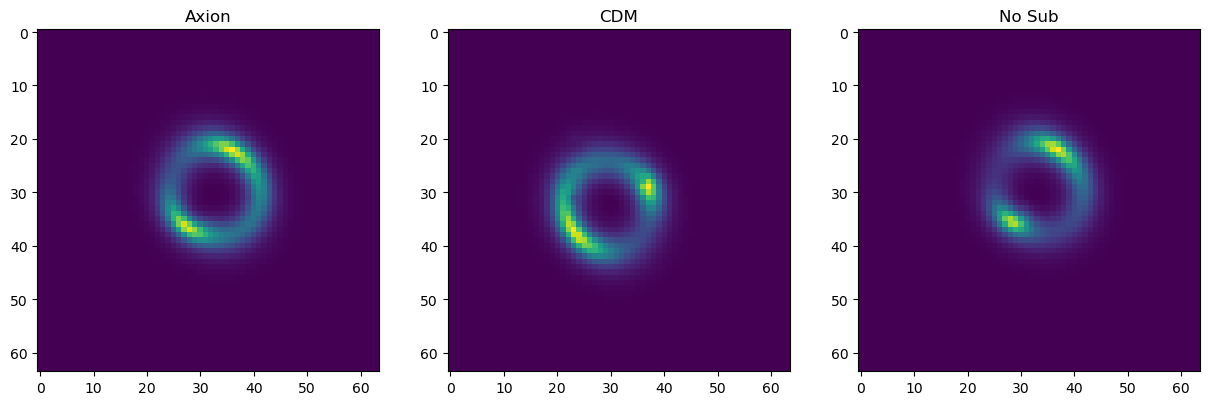

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(axion_data[0][0])
axes[0].set_title("Axion")

axes[1].imshow(cdm_data[0][0])
axes[1].set_title("CDM")

axes[2].imshow(no_sub_data[0][0])
axes[2].set_title("No Sub")

In [ ]:
axion_data = augment_images(np.array(axion_data), 5)
cdm_data = augment_images(np.array(cdm_data), 5)
no_sub_data = augment_images(np.array(no_sub_data), 5)

# Creating the common dataset and dataloader
Labels = ([0]*len(axion_data) + [1]*len(cdm_data) + [2]*len(no_sub_data))
Data = axion_data + cdm_data + no_sub_data

Data = torch.tensor(Data, dtype=torch.float32)
Labels = torch.tensor(Labels, dtype=torch.long)

dataset = CustomDataset(Data, Labels)
train, test = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
TrainLoader = DataLoader(train, batch_size=128, shuffle=True)
TestLoader = DataLoader(test, batch_size=128, shuffle=True)

ValueError: operands could not be broadcast together with shapes (149480,1,64,64) (148795,1,64,64) 

In [ ]:
Encoder = MaskedAutoEncoder(patch_size=8).to("mps")
Encoder.load_state_dict(torch.load("../ModelWeights/MaskedAutoEncoder__Very_VeryDeep_Final__Solution.pth"))

/var/folders/mh/r3bzvtd11h105hlbbgl239940000gn/T/ipykernel_98234/1600658924.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Encoder.load_state_dict(torch.load("../ModelW

<All keys matched successfully>

In [ ]:
Classifier = MAEViTClassifier(Encoder=Encoder, hidden_size=1024, num_classes=3).to("mps")

100%|██████████| 140/140 [01:02<00:00,  2.23it/s]



Epoch 1/50 -
	Training Loss: 1.19819805117013 
	Accuracy: 42.72351885098743
	AUC Score: 0.5019443886517359

	Val Loss: 1.1938759011881692 
	Val Accuracy: 42.542857142857144
	Val AUC Score: 0.5040023665118037



100%|██████████| 140/140 [01:03<00:00,  2.19it/s]



Epoch 11/50 -
	Training Loss: 1.1983399740027354 
	Accuracy: 42.73429084380611
	AUC Score: 0.5037436301287965

	Val Loss: 1.1942569051470076 
	Val Accuracy: 42.542857142857144
	Val AUC Score: 0.5030907204057804



 25%|██▌       | 142/557 [02:47<08:08,  1.18s/it]


KeyboardInterrupt: 

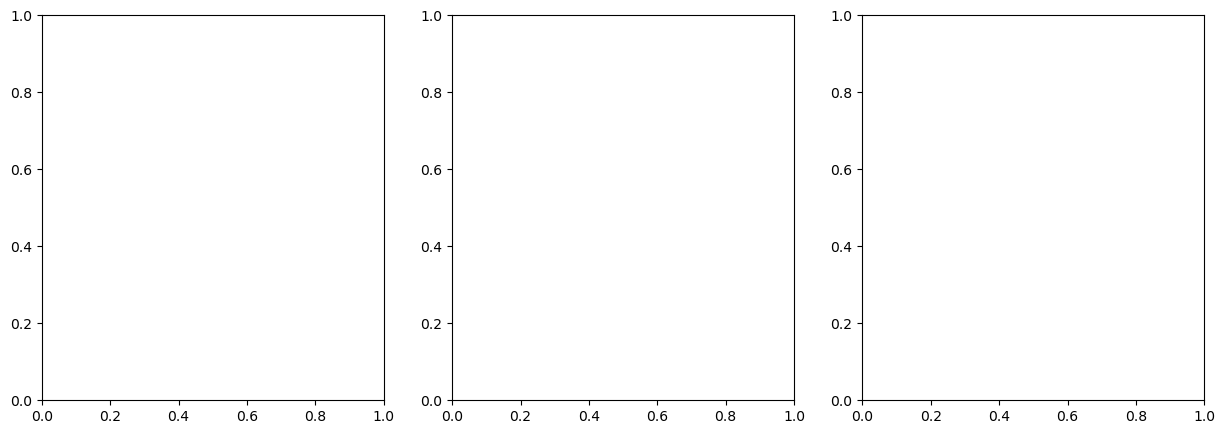

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Train(Classifier, TrainLoader, TestLoader, criterion, optimizer, epochs=50, device='mps', scheduler=scheduler)